In [19]:
import sys
import numpy as np
import pyspark
from pyspark.ml.recommendation import ALS
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, FloatType, IntegerType, LongType
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.utils.notebook_utils import is_jupyter
from recommenders.datasets.spark_splitters import spark_random_split
from recommenders.evaluation.spark_evaluation import SparkRatingEvaluation, SparkRankingEvaluation
from recommenders.utils.spark_utils import start_or_get_spark

print("System version: {}".format(sys.version))
print("Spark version: {}".format(pyspark.__version__))

System version: 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]
Spark version: 3.3.1


<h1>Set up spark context</h1>

In [20]:
# the following settings work well for debugging locally on VM - change when running on a cluster
# set up a giant single executor with many threads and specify memory cap
spark = start_or_get_spark("ALS PySpark", memory="10g")
spark.conf.set("spark.sql.analyzer.failAmbiguousSelfJoin", "false")

In [21]:
spark.sparkContext.setCheckpointDir('./checkpoints')

<h1>Load the dataset</h1>

In [22]:
# Column names for the dataset
COL_USER = "UserId"
COL_ITEM = "ItemId"
COL_RATING = "Rating"
COL_TIMESTAMP = "Timestamp"

In [24]:
dataset_name = 'sas'

In [25]:
train_path, test_path = '../data/{}/train.csv'.format(dataset_name), '../data/{}/test.csv'.format(dataset_name)

In [26]:
# Note: The DataFrame-based API for ALS currently only supports integers for user and item ids.
schema = StructType(
    (
        StructField(COL_USER, IntegerType()),
        StructField(COL_ITEM, IntegerType()),
        StructField(COL_RATING, FloatType()),
        StructField(COL_TIMESTAMP, LongType()),
    )
)

train = spark.read.load(train_path, format="csv", header="true", sep=',', schema=schema)
test = spark.read.load(test_path, format="csv", header="true", sep=',', schema=schema)

In [27]:
print ("N train", train.cache().count())
print ("N test", test.cache().count())

N train 164525
N test 44568


<h1>Train ALS</h1>

In [28]:
header = {
    "userCol": COL_USER,
    "itemCol": COL_ITEM,
    "ratingCol": COL_RATING,
}

als = ALS(
    rank=40,
    maxIter=35,
    implicitPrefs=False,
    regParam=0.08,
    coldStartStrategy='drop',
    nonnegative=True,
    seed=42,
    **header
)

In [29]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol=COL_RATING, predictionCol="prediction")

In [30]:
with Timer() as train_time:
    model = als.fit(train)
    predictions = model.transform(test)
    rmse = evaluator.evaluate(predictions)
    print(f"Root-mean-square error = {rmse}")

print("Took {} seconds for training.".format(train_time.interval))

Root-mean-square error = 0.8328319236116101
Took 11.333692374999373 seconds for training.


- In the movie recommendation use case, recommending movies that have been rated by the users do not make sense. (because they have already seen them)

- Therefore, the rated movies are removed from the recommended items.

- In order to achieve this, we recommend all movies to all users, and then remove the user-movie pairs that exist in the training dataset.

In [31]:
userRecs = model.recommendForAllUsers(100)

rows = []
for row in userRecs.collect():
    for rec in row['recommendations']:
        rows.append([row['UserId'], rec['ItemId'], rec['rating']])
        
schema = StructType([
    StructField("UserId", IntegerType(), True),
    StructField("ItemId", IntegerType(), True),
    StructField("prediction", FloatType(), True)
])

top_k_df = spark.createDataFrame(rows, schema=schema)
# Show the top_k_df DataFrame
top_k_df.show()

23/05/08 08:13:56 WARN TaskSetManager: Stage 534 contains a task of very large size (9794 KiB). The maximum recommended task size is 1000 KiB.


23/05/08 08:14:00 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 534 (TID 2178): Attempting to kill Python Worker
+------+------+----------+
|UserId|ItemId|prediction|
+------+------+----------+
|    26|    37| 1.3530378|
|    26|   834| 1.2740134|
|    26|  1056| 1.1821141|
|    26|  1190| 1.1801662|
|    26|   660| 1.1627798|
|    26|   964|  1.159298|
|    26|   956| 1.1572847|
|    26|  1155| 1.1526268|
|    26|   890| 1.1485099|
|    26|   647| 1.1295681|
|    26|  1549| 1.1257792|
|    26|   893| 1.1008624|
|    26|   875| 1.0888025|
|    26|   134| 1.0834347|
|    26|   963| 1.0814934|
|    26|   967| 1.0724463|
|    26|   108| 1.0666947|
|    26|    38| 1.0635729|
|    26|  1057| 1.0609869|
|    26|   871| 1.0529557|
+------+------+----------+
only showing top 20 rows



In [32]:
# Remove seen items.
dfs_pred_exclude_train = top_k_df.alias("pred").join(
    train.alias("train"),
    (top_k_df[COL_USER] == train[COL_USER]) & (top_k_df[COL_ITEM] == train[COL_ITEM]),
    how='outer'
)

# train.{col_rating} will be null on the previous step, if this pair was not seen before. These are the entries of interest to us.
top_ex = dfs_pred_exclude_train.filter(dfs_pred_exclude_train[f"train.{COL_RATING}"].isNull()) \
        .select('pred.' + COL_USER, 'pred.' + COL_ITEM, 'pred.' + "prediction")


<h1>Evaluate how well ALS performs</h1>

In [43]:
# Needs all the predictions, to calculate Top-K, NDCG, etc.
# top_k_df
rank_eval = SparkRankingEvaluation(test, top_ex, k = 10, col_user=COL_USER, col_item=COL_ITEM, 
                                    col_rating=COL_RATING, col_prediction="prediction", 
                                    relevancy_method="top_k")

23/05/08 08:18:53 WARN TaskSetManager: Stage 612 contains a task of very large size (9794 KiB). The maximum recommended task size is 1000 KiB.


In [44]:
print("Model:\tALS",
      "Top K:\t%d" % rank_eval.k,
      "MAP:\t%f" % rank_eval.map_at_k(),
      "NDCG:\t%f" % rank_eval.ndcg_at_k(),
      "Precision@K:\t%f" % rank_eval.precision_at_k(),
      "Recall@K:\t%f" % rank_eval.recall_at_k(), sep='\n')

23/05/08 08:18:58 WARN TaskSetManager: Stage 625 contains a task of very large size (9794 KiB). The maximum recommended task size is 1000 KiB.


Model:	ALS
Top K:	10
MAP:	0.006878
NDCG:	0.011562
Precision@K:	0.004392
Recall@K:	0.018014


<h1>Evaluate rating prediction</h1>

In [45]:
# Generate predicted ratings.
prediction = model.transform(test)
prediction.cache().show()

+------+------+------+----------+----------+
|UserId|ItemId|Rating| Timestamp|prediction|
+------+------+------+----------+----------+
| 37858|   148|   3.0|1494523560|0.78494215|
|  9126|   148|   1.0|1498616460|  0.948777|
|  9523|   148|   2.0|1496061960| 0.8916069|
|  2108|   148|   1.0|1498011480| 1.0486164|
| 26768|   148|   1.0|1495717560|0.92006576|
| 40994|   148|   1.0|1498592820| 1.0097954|
| 27728|   148|   2.0|1498505640| 1.6772659|
| 26443|   148|   1.0|1498597080| 0.6891885|
| 33475|   148|   1.0|1495197540| 0.9585293|
| 31490|   148|   1.0|1494693240| 0.9441744|
| 35733|   148|   1.0|1494852240|  1.680727|
| 23674|   148|   1.0|1498153500|  1.917714|
|  2903|   148|   1.0|1497788160| 1.0351653|
| 13378|   148|   1.0|1497623940| 0.9261995|
| 18628|   148|   1.0|1495149540| 1.0889461|
| 43752|   148|   1.0|1498580640| 0.5441003|
| 31411|   148|   1.0|1497296580|0.92273307|
| 43382|   148|   1.0|1495226220| 1.1357262|
| 43058|   148|   1.0|1494879180| 1.1398259|
|  2378|  

In [46]:
rating_eval = SparkRatingEvaluation(test, prediction, col_user=COL_USER, col_item=COL_ITEM, 
                                    col_rating=COL_RATING, col_prediction="prediction")

print("Model:\tALS rating prediction",
      "RMSE:\t%f" % rating_eval.rmse(),
      "MAE:\t%f" % rating_eval.mae(),
      "Explained variance:\t%f" % rating_eval.exp_var(),
      "R squared:\t%f" % rating_eval.rsquared(), sep='\n')

Model:	ALS rating prediction
RMSE:	0.844874
MAE:	0.505405
Explained variance:	0.596282
R squared:	0.560372


<h3>SAS RFM</h3>

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

In [51]:
rfm = pd.read_parquet('../data/sas/mart/rfm_mapped.parquet')
rfm_levels = ["Can't Loose Them", "Champions", "Loyal", "Potential", "Sleeping", "Require Activation"]

In [57]:
merged_pred = top_ex.toPandas()
merged_test = test.toPandas()

In [64]:
merged_test = merged_test.rename(columns={'UserId': 'userID', 'ItemId': 'itemID', 'Rating': 'rating'})
merged_pred = merged_pred.rename(columns={'UserId': 'userID', 'ItemId': 'itemID'})

In [66]:
TOP_K = 10
NDCGs = []
for level in rfm_levels:
    users = rfm[rfm['RFM_Level'] == level]['phone'].unique()

    m_test_s = merged_test[merged_test['userID'].isin(users)]
    m_pred_s = merged_pred[merged_pred['userID'].isin(users)]

    print(m_test_s.shape, m_pred_s.shape)

    eval_map = map_at_k(m_test_s, m_pred_s, col_prediction='prediction', k=TOP_K)
    eval_ndcg = ndcg_at_k(m_test_s, m_pred_s, col_prediction='prediction', k=TOP_K)

    NDCGs.append(eval_ndcg)

(5806, 4) (280688, 3)
(3557, 4) (287635, 3)
(4122, 4) (422100, 3)
(4400, 4) (581132, 3)
(2720, 4) (507380, 3)
(574, 4) (192009, 3)


In [67]:
for level, ndcg in zip(rfm_levels, NDCGs):
    print(level, np.round(ndcg, 4))

Can't Loose Them 0.0071
Champions 0.0052
Loyal 0.0061
Potential 0.006
Sleeping 0.0127
Require Activation 0.0229


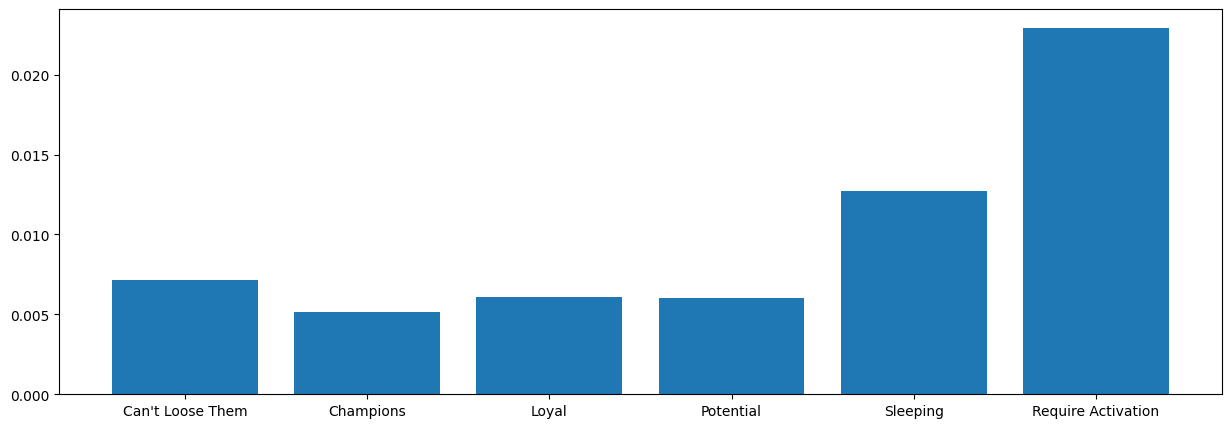

In [70]:
plt.figure(figsize=(15,5))
plt.bar(rfm_levels, NDCGs);

In [18]:
# cleanup spark instance
spark.stop()

In [ ]:
#from annoy import AnnoyIndex
#from tqdm import tqdm
#
#with Timer() as test_time:
##

    # Extract user and item factors
#    user_factors = model.userFactors
#    item_factors = model.itemFactors

    # Create an Annoy index with the same number of dimensions as the item factors
#    embedding_dimension = len(item_factors.select("features").first()[0])
#    annoy_index = AnnoyIndex(embedding_dimension, 'angular')

    # Add item factors to the Annoy index
#    item_factors_list = item_factors.select("id", "features").collect()
#    for item in item_factors_list:
#        annoy_index.add_item(item["id"], item["features"])

    # Build the Annoy index
#    annoy_index.build(100) # You can adjust the number of trees to balance search speed and accuracy

    # Find top K recommendations for each user
#    K = 100
#    top_k_recommendations = {}

#    for user in tqdm(user_factors.select("id", "features").collect()):
#        user_id = user["id"]
#        user_embedding = user["features"]
#        nearest_item_ids = annoy_index.get_nns_by_vector(user_embedding, K)
#        top_k_recommendations[user_id] = nearest_item_ids

In [ ]:
#with Timer() as test_time:

    # Get the cross join of all user-item pairs and score them.
#    users = train.select(COL_USER).distinct()
#    items = train.select(COL_ITEM).distinct()
#    user_item = users.crossJoin(items)
#    dfs_pred = model.transform(user_item)

    # Remove seen items.
#    dfs_pred_exclude_train = dfs_pred.alias("pred").join(
#        train.alias("train"),
#        (dfs_pred[COL_USER] == train[COL_USER]) & (dfs_pred[COL_ITEM] == train[COL_ITEM]),
#        how='outer'
#    )

    # train.{col_rating} will be null on the previous step, if this pair was not seen before. These are the entries of interest to us.
#    top_all = dfs_pred_exclude_train.filter(dfs_pred_exclude_train[f"train.{COL_RATING}"].isNull()) \
#        .select('pred.' + COL_USER, 'pred.' + COL_ITEM, 'pred.' + "prediction")

    # In Spark, transformations are lazy evaluation
    # Use an action to force execute and measure the test time 
#    top_all.cache().count()

#print("Took {} seconds for prediction.".format(test_time.interval))